In [1]:
import os
import re
import math
import time
import torch
import random
import warnings
import numpy as np
import pandas as pd
import torch.nn as nn
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score, classification_report
from accelerate import Accelerator, notebook_launcher
from torch.multiprocessing import Manager
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertModel, BertPreTrainedModel, BertConfig, BertForSequenceClassification

# SETUP

In [2]:
warnings.filterwarnings('ignore')

In [3]:
if os.path.exists('/kaggle/working/results') == False:
    os.mkdir('/kaggle/working/results')

if os.path.exists('/kaggle/working/acquired_data') == False:
    os.mkdir('/kaggle/working/acquired_data')

In [4]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic=True
    torch.backends.cudnn.benchmark=False

set_seed(50)

# GLOBAL VARIABLES

In [5]:
manager = Manager()

# Shared resources
accuracies = manager.list()
f1_micros = manager.list()
f1_macros = manager.list()
data_used = manager.list()
sampling_dur = manager.list()
new_samples = manager.list()

# Non shared resources
epochs = 10
batch_size = 64
sequence_length = 80

# LOAD AND PREPROCESS DATA

In [6]:
data = pd.read_csv('/kaggle/input/multi-label-hate-speech-3/re_dataset.csv', encoding='latin-1')

alay_dict = pd.read_csv('/kaggle/input/multi-label-hate-speech-3/new_kamusalay.csv', encoding='latin-1', header=None)
alay_dict = alay_dict.rename(columns={0: 'original', 
                                      1: 'replacement'})

print("Shape: ", data.shape)
data.head()

Shape:  (13169, 13)


,Tweet,HS,Abusive,HS_Individual,HS_Group,HS_Religion,HS_Race,HS_Physical,HS_Gender,HS_Other,HS_Weak,HS_Moderate,HS_Strong
0,- disaat semua cowok berusaha melacak perhatia...,1,1,1,0,0,0,0,0,1,1,0,0
1,RT USER: USER siapa yang telat ngasih tau elu?...,0,1,0,0,0,0,0,0,0,0,0,0
2,"41. Kadang aku berfikir, kenapa aku tetap perc...",0,0,0,0,0,0,0,0,0,0,0,0
3,USER USER AKU ITU AKU\n\nKU TAU MATAMU SIPIT T...,0,0,0,0,0,0,0,0,0,0,0,0
4,USER USER Kaum cebong kapir udah keliatan dong...,1,1,0,1,1,0,0,0,0,0,1,0


In [7]:
def lowercase(text):
    return text.lower()

def remove_unnecessary_char(text):
    text = re.sub('\n',' ',text) # Remove every '\n'
    text = re.sub('rt',' ',text) # Remove every retweet symbol
    text = re.sub('user',' ',text) # Remove every username
    text = re.sub('url', ' ', text) # Remove every URL
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+)|(http?://[^\s]+))',' ',text) # Remove every URL
    text = re.sub(r'\b(?:x[a-fA-F0-9]{2}\s*)+\b', '', text) # Remove emoji bytecode
    text = re.sub('  +', ' ', text) # Remove extra spaces
    return text
    
def remove_nonaplhanumeric(text):
    text = re.sub('[^0-9a-zA-Z]+', ' ', text) 
    return text

alay_dict_map = dict(zip(alay_dict['original'], alay_dict['replacement']))
def normalize_alay(text):
    return ' '.join([alay_dict_map[word] if word in alay_dict_map else word for word in text.split(' ')])

print("remove_nonaplhanumeric: ", remove_nonaplhanumeric("Halooo,,,,, duniaa \x8f \xd2\1 !!"))
print("lowercase: ", lowercase("Halooo, duniaa!"))
print("remove_unnecessary_char: ", remove_unnecessary_char("Hehe\n\n RT USER USER apa kabs www.google.com\n  hehe URL xf8 x2a x89"))
print("normalize_alay: ", normalize_alay("aamiin adek abis"))

remove_nonaplhanumeric:  Halooo duniaa 
lowercase:  halooo, duniaa!
remove_unnecessary_char:  Hehe RT USER USER apa kabs hehe URL 
normalize_alay:  amin adik habis


In [8]:
def preprocess(text):
    text = lowercase(text)
    text = remove_nonaplhanumeric(text)
    text = remove_unnecessary_char(text)
    text = normalize_alay(text) 

    return text

In [9]:
data['Tweet'] = data['Tweet'].apply(preprocess)

# Define the labels columns for multi-label classification
label_columns = data.columns[1:]  # Assuming label columns start from the third column

train_data, val_data = train_test_split(data, test_size=0.2, random_state=42, shuffle=False)

# Extract features and labels for training and validation
X_train = train_data['Tweet'].values
y_train = train_data[label_columns].values
X_val = val_data['Tweet'].values
y_val = val_data[label_columns].values

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(10535,) (10535, 12)
(2634,) (2634, 12)


# BULDING DATASET

In [10]:
class HateSpeechDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128, use_float=True):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.use_float = use_float

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        labels = self.labels[idx]
        encoding = self.tokenizer(text, truncation=True, padding='max_length', max_length=self.max_length, return_tensors='pt')
        item = {key: val.squeeze() for key, val in encoding.items()}
        item['labels'] = torch.tensor(labels, dtype=torch.float if self.use_float else torch.long)
        return item

# Initialize BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p1')

tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/229k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

In [11]:
def get_dataloaders(X_train, y_train, X_val, y_val, sequence_length=sequence_length, num_workers=4):
    train_dataset = HateSpeechDataset(X_train, y_train, tokenizer, max_length=sequence_length)
    val_dataset = HateSpeechDataset(X_val, y_val, tokenizer, max_length=sequence_length)
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=num_workers
    )
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=num_workers
    )

    return train_loader, val_loader

In [12]:
total_data = len(X_train) + len(X_val)
initial_train_size = int(0.05 * total_data)
checkpoints = [
    int(0.5 * total_data), 
    int(0.6 * total_data), 
    int(0.7 * total_data),
    len(X_train)
]
min_increment = 200

In [13]:
def compute_metrics(p):
    preds = torch.tensor(p.predictions) # Sigmoid and threshold for multi-label
    labels = torch.tensor(p.label_ids)

    # Hamming accuracy: proportion of correctly predicted labels over total labels
    accuracy = (preds == labels).float().mean().item()

    # Standard multi-label precision, recall, and F1 metrics
    precision, recall, f1_micro, _ = precision_recall_fscore_support(labels, preds, average='micro', zero_division=0)
    _, _, f1_macro, _ = precision_recall_fscore_support(labels, preds, average='macro', zero_division=0)

    report = classification_report(
        labels, 
        preds, 
        target_names=['HS', 'Abusive', 'HS_Individual', 'HS_Group', 'HS_Religion', 'HS_Race', 'HS_Physical', 'HS_Gender', 'HS_Other', 'HS_Weak', 'HS_Moderate', 'HS_Strong'],
        zero_division=0
    )   
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_micro': f1_micro,
        'f1_macro': f1_macro,
        'report': report
    }

In [14]:
def train_model(current_train_size, train_indices, metrics, trials, seed, filename):
    accelerator = Accelerator(mixed_precision='fp16')
    device = accelerator.device
    accelerator.print(accelerator.distributed_type)

    with accelerator.main_process_first():
        model = BertForSequenceClassification.from_pretrained(
            'indobenchmark/indobert-base-p1',
            num_labels=len(label_columns),
            problem_type="multi_label_classification"
        )

    # Freeze the first few layers of the encoder
    for name, param in model.named_parameters():
        if "encoder.layer" in name:
            layer_num = name.split(".")[3]
            try:
                if int(layer_num) < 6:
                    param.requires_grad = False
            except ValueError:
                continue

    # Define DataLoaders
    current_X_train = [X_train[i] for i in train_indices]
    current_y_train = [y_train[i] for i in train_indices]
    train_loader, val_loader = get_dataloaders(current_X_train, current_y_train, X_val, y_val)

    # Define optimizer and loss function
    optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)
    loss_fn = torch.nn.BCEWithLogitsLoss()

    # Prepare everything with Accelerator
    model, optimizer, train_loader, val_loader = accelerator.prepare(
        model, optimizer, train_loader, val_loader
    )

    best_result = None
    start_time = time.time()

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0

        for batch in train_loader:
            inputs = {key: val for key, val in batch.items() if key != 'labels'}
            labels = batch['labels']

            optimizer.zero_grad()
            outputs = model(**inputs)
            loss = loss_fn(outputs.logits, labels)
            accelerator.backward(loss)
            optimizer.step()

            epoch_loss += loss.item()

        # Evaluation
        model.eval()
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for batch in val_loader:
                inputs = {key: val for key, val in batch.items() if key != 'labels'}
                labels = batch['labels']
                
                outputs = model(**inputs)
                preds = torch.sigmoid(outputs.logits).round()

                # Gather predictions and labels from all devices
                all_preds.append(accelerator.gather(preds))
                all_labels.append(accelerator.gather(labels))

        all_preds = torch.cat(all_preds).cpu().numpy()
        all_labels = torch.cat(all_labels).cpu().numpy()

        result = compute_metrics(type('EvalOutput', (object,), {'predictions': all_preds, 'label_ids': all_labels}))

        if best_result is None or result['f1_micro'] >= best_result['f1_micro']:
            accelerator.print("Higher F1 achieved, saving model")

            nearest_cp = current_train_size
            if nearest_cp not in checkpoints:
                for cp in checkpoints:
                    if cp > current_train_size:
                        nearest_cp = cp
                        break
            percentage = math.ceil(nearest_cp / total_data * 100)
            
            accelerator.wait_for_everyone()
            unwrapped_model = accelerator.unwrap_model(model)
            unwrapped_model.save_pretrained(
                f'{filename}-model-{percentage}',
                is_main_process=accelerator.is_main_process,
                save_function=accelerator.save,
            )
            best_result = result

        accelerator.print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {round(epoch_loss / len(train_loader), 4)}, Accuracy: {round(result['accuracy'], 4)}, F1 Micro: {round(result['f1_micro'], 4)}, F1 Macro: {round(result['f1_macro'], 4)}")

    end_time = time.time()
    duration = end_time - start_time
    
    accelerator.print(f"\n Iteration {current_train_size}: Accuracy: {round(best_result['accuracy'], 4)}, F1 Micro: {round(best_result['f1_micro'], 4)}, F1 Macro: {round(best_result['f1_macro'], 4)}")
    accelerator.print(best_result['report'])
    accelerator.print(f"Training completed in {duration} s")

    # Update the shared lists
    if accelerator.is_local_main_process:
        metrics[0].append(current_train_size)
        metrics[1].append(best_result['accuracy'])
        metrics[2].append(best_result['f1_micro'])
        metrics[3].append(best_result['f1_macro'])

In [15]:
import matplotlib.pyplot as plt

def plot_result(data_used, accuracies, f1_micros, f1_macros):
    fig, axs = plt.subplots(1, 3, figsize=(21, 5))
    data_used = [round(data / total_data * 100, 1) for data in data_used]

    # Plot for Accuracy
    axs[0].plot(data_used, accuracies, label="Accuracy", color="blue")
    axs[0].set_xlabel("Percentage of data used")
    axs[0].set_title("Accuracy")
    axs[0].set_xticks(data_used)

    # Plot for F1 Micro
    axs[1].plot(data_used, f1_micros, label="F1 Micro", color="orange")
    axs[1].set_xlabel("Percentage of data used")
    axs[1].set_title("F1 Micro")
    axs[1].set_xticks(data_used)

    # Plot for F1 Macro
    axs[2].plot(data_used, f1_macros, label="F1 Macro", color="green")
    axs[2].set_xlabel("Percentage of data used")
    axs[2].set_title("F1 Macro")
    axs[2].set_xticks(data_used)

    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()

In [16]:
def combined_sampling(model, X_pool, train_indices, remaining_indices, tokenizer, sampling_dur, new_samples, trials, filename):
    accelerator = Accelerator(mixed_precision="fp16")
    device = accelerator.device
    model.to(device)
    
    current_train_size = len(train_indices)
    
    # Check nearest checkpoint
    nearest_cp = 0
    for cp in checkpoints:
        if cp > current_train_size:
            nearest_cp = cp
            break

    target_samples = math.ceil(0.1*len(remaining_indices))
    if target_samples <= min_increment and min_increment < nearest_cp - current_train_size:
        target_samples = min_increment
    elif target_samples > min_increment and target_samples < nearest_cp - current_train_size:
        target_samples = target_samples
    else:
        target_samples = nearest_cp - current_train_size

    accelerator.print(current_train_size, checkpoints[-1] - target_samples)
    final_cp = False
    # No sampling needed when there's little data left or we've reached the last checkpoint
    
    if current_train_size >= checkpoints[-1] - target_samples:
        final_cp = True

        if accelerator.is_main_process:
            temp = train_indices.copy()
            temp.extend(remaining_indices)
            
            # Save acquired data up to checkpoint
            acquired_data = pd.DataFrame({
                'processed_text': [X_train[i] for i in temp],
                'HS': [y_train[i][0] for i in temp],
                'Abusive': [y_train[i][1] for i in temp],
                'HS_Individual': [y_train[i][2] for i in temp],
                'HS_Group': [y_train[i][3] for i in temp],
                'HS_Religion': [y_train[i][4] for i in temp],
                'HS_Race': [y_train[i][5] for i in temp],
                'HS_Physical': [y_train[i][6] for i in temp],
                'HS_Gender': [y_train[i][7] for i in temp],
                'HS_Other': [y_train[i][8] for i in temp],
                'HS_Weak': [y_train[i][9] for i in temp],
                'HS_Moderate': [y_train[i][10] for i in temp],
                'HS_Strong': [y_train[i][11] for i in temp],
            })
            acquired_data.to_csv(f'acquired_data/{filename}-data-{nearest_cp}.csv', index=False)
            
            print("Nearest checkpoint:", nearest_cp)
            print("Acquired samples:", len(remaining_indices))
            
            sampling_dur.append(0)
            for i in remaining_indices:
                new_samples.append(i)

    accelerator.wait_for_everyone()
    if not final_cp:
        # Create dataset and dataloader for both methods
        dataset = HateSpeechDataset(X_pool, np.zeros((len(X_pool), 4)), tokenizer, max_length=sequence_length)
        dataloader = DataLoader(
            dataset,
            batch_size=batch_size,
            num_workers=4,
            pin_memory=True,
        )
        
        # Start timing
        start_time = time.time()
        
        # Get KMeans samples
        kmeans_indices = get_kmeans_samples(model, dataloader, device, target_samples)
        kmeans_indices = [remaining_indices[i] for i in kmeans_indices]
        accelerator.print(f"Got {len(kmeans_indices)} samples from kmeans")
        
        # Get Least Confidence samples
        lc_indices = get_least_confidence_samples(model, dataloader, device, target_samples)
        lc_indices = [remaining_indices[i] for i in lc_indices]
        accelerator.print(f"Got {len(lc_indices)} samples from lc")
    
        if accelerator.is_main_process:
            # Combine both methods' results
            combined_indices = list(set(kmeans_indices).union(set(lc_indices)))
            
            # If we got more than we need, take only what we need
            if len(combined_indices) > target_samples:
                np.random.shuffle(combined_indices)
                combined_indices = combined_indices[:target_samples]
            
            # Calculate duration
            end_time = time.time()
            duration = end_time - start_time
            
            # Check if we've reached a checkpoint
            if current_train_size + len(combined_indices) >= nearest_cp:
                temp = train_indices.copy()
                temp.extend(combined_indices)
                
                # Save acquired data up to checkpoint
                acquired_data = pd.DataFrame({
                    'processed_text': [X_train[i] for i in temp],
                    'HS': [y_train[i][0] for i in temp],
                    'Abusive': [y_train[i][1] for i in temp],
                    'HS_Individual': [y_train[i][2] for i in temp],
                    'HS_Group': [y_train[i][3] for i in temp],
                    'HS_Religion': [y_train[i][4] for i in temp],
                    'HS_Race': [y_train[i][5] for i in temp],
                    'HS_Physical': [y_train[i][6] for i in temp],
                    'HS_Gender': [y_train[i][7] for i in temp],
                    'HS_Other': [y_train[i][8] for i in temp],
                    'HS_Weak': [y_train[i][9] for i in temp],
                    'HS_Moderate': [y_train[i][10] for i in temp],
                    'HS_Strong': [y_train[i][11] for i in temp],
                })
                acquired_data.to_csv(f'acquired_data/{filename}-data-{nearest_cp}.csv', index=False)
            
            # Log results
            print("Nearest checkpoint:", nearest_cp)
            print(f"Acquired samples: {len(combined_indices)}")
            print(f"Sampling duration: {duration} seconds")
            
            sampling_dur.append(duration)
            for i in combined_indices:
                new_samples.append(i)

def get_kmeans_samples(model, dataloader, device, n_samples, n_clusters=min_increment):
    model.eval()
    embeddings = []
    
    # Get embeddings
    with torch.no_grad():
        for data in dataloader:
            input_ids = data['input_ids'].to(device)
            attention_mask = data['attention_mask'].to(device)
            outputs = model.base_model(input_ids=input_ids, attention_mask=attention_mask)
            hidden_states = outputs.last_hidden_state.mean(dim=1)  # Mean of hidden states for vector representation
            embeddings.append(hidden_states.cpu().numpy())
    
    # Convert embeddings list to numpy array
    embeddings = np.vstack(embeddings)
    
    # Cluster the data based on its embeddings
    kmeans = KMeans(n_clusters=n_clusters, n_init=1)
    kmeans.fit(embeddings)
    
    collected_indices = set()  # Initialize set to store selected indices
    
    for cluster_id in range(n_clusters):
        # Cluster center and indices of samples in the current cluster
        cluster_center = kmeans.cluster_centers_[cluster_id]
        cluster_indices = np.where(kmeans.labels_ == cluster_id)[0]
        
        if cluster_indices.size == 0:
            # Skip clusters with no members
            continue
        
        # Calculate distances of each point in the cluster from the cluster center
        cluster_distances = np.linalg.norm(embeddings[cluster_indices] - cluster_center, axis=1)
        
        # Determine the local threshold (90th percentile of distances to cluster center)
        local_threshold = np.percentile(cluster_distances, 90)
        
        # Get indices of points with distances greater than or equal to threshold
        below_threshold_indices = cluster_indices[cluster_distances >= local_threshold]
        collected_indices.update(below_threshold_indices)
    
    # Randomly shuffle and select required number of samples
    collected_indices = np.array(list(collected_indices))
    
    # Return only the requested number of samples
    return collected_indices[:n_samples]

def get_least_confidence_samples(model, dataloader, device, n_samples):
    model.eval()
    uncertainties = []
    
    # Calculate uncertainties
    for data in dataloader:
        input_ids = data['input_ids'].to(device, non_blocking=True)
        attention_mask = data['attention_mask'].to(device, non_blocking=True)
        with torch.no_grad():
            outputs = model(input_ids=input_ids, attention_mask=attention_mask).logits
        
        for output in outputs:
            probs = torch.sigmoid(output).cpu().numpy()
            uncertainty = np.absolute(1 - np.max(probs))
            uncertainties.append(uncertainty)
    
    uncertainties = np.array(uncertainties)
    sorted_unc = np.argsort(uncertainties)
    sorted_unc = sorted_unc[::-1]  # Reverse to get highest uncertainty first

    threshold = np.percentile(uncertainties, 90)
    items_greater_than_average = uncertainties[uncertainties >= threshold]
    least_confident_indices = sorted_unc[:n_samples]

    return least_confident_indices

In [17]:
def active_learning(seed, i):
    accuracies = manager.list()
    f1_micros = manager.list()
    f1_macros = manager.list()
    data_used = manager.list()
    sampling_dur = manager.list()
    new_samples = manager.list()
    filename = 'hsd-lc-kmeans'

    set_seed(seed)
    
    print("===============================================")
    print("TRIAL {}".format(i+1))
    print("Random seed:", seed)
    
    train_indices = np.random.choice(range(len(X_train)), initial_train_size, replace=False).tolist()
    remaining_indices = list(set(range(len(X_train))) - set(train_indices))
    
    current_train_size = initial_train_size
    
    start_time = time.time()
    while current_train_size < checkpoints[len(checkpoints) - 1]:
        # Train the model
        args = (current_train_size, train_indices, (data_used, accuracies, f1_micros, f1_macros), i, seed, filename)
        notebook_launcher(train_model, args, num_processes=2)

        nearest_cp = current_train_size
        if nearest_cp not in checkpoints:
            for cp in checkpoints:
                if cp > current_train_size:
                    nearest_cp = cp
                    break
        percentage = math.ceil(nearest_cp / total_data * 100)
        
        model = BertForSequenceClassification.from_pretrained(f'{filename}-model-{percentage}')
    
        # Perform query strategy to select new samples
        new_samples = manager.list()
        sampling_args = (model, [X_train[i] for i in remaining_indices], train_indices, remaining_indices, tokenizer, sampling_dur, new_samples, i, filename)
        notebook_launcher(combined_sampling, sampling_args, num_processes=2)
        new_samples = list(new_samples)
        train_indices.extend(new_samples)
        remaining_indices = list(set(remaining_indices) - set(new_samples))
    
        # Update current training size
        current_train_size = len(train_indices)
        print("New train size: {}".format(current_train_size))
    
    # Train last epoch
    args = (current_train_size, train_indices, (data_used, accuracies, f1_micros, f1_macros), i, seed, filename)
    notebook_launcher(train_model, args, num_processes=2)
    data_used, accuracies, f1_micros, f1_macros, sampling_dur = list(data_used), list(accuracies), list(f1_micros), list(f1_macros), list(sampling_dur)
    
    end_time = time.time()
    duration = end_time - start_time
    
    print(f"Total sampling time: {np.array(sampling_dur).sum().round(2)} seconds")
    print(f"Total runtime: {duration} seconds")
    
    plot_result(data_used, accuracies, f1_micros, f1_macros)
    
    results = pd.DataFrame({
        'Data Used': data_used,
        'Accuracy': accuracies,
        'F1 Micro': f1_micros,
        'F1 Macro': f1_macros,
    })
    
    sampling_dur.insert(0, 0)
    results['Sampling Duration'] = sampling_dur
    results.to_csv(f'results/{filename}-results.csv', index=False)

In [18]:
seeds = [50, 81, 14, 3, 94]

TRIAL 1
Random seed: 50
Launching training on 2 GPUs.
DistributedType.MULTI_GPU


pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6065, Accuracy: 0.8198, F1 Micro: 0.122, F1 Macro: 0.0444
Epoch 2/10, Train Loss: 0.4617, Accuracy: 0.8278, F1 Micro: 0.0007, F1 Macro: 0.0003
Epoch 3/10, Train Loss: 0.3954, Accuracy: 0.8278, F1 Micro: 0.0, F1 Macro: 0.0
Epoch 4/10, Train Loss: 0.3949, Accuracy: 0.8281, F1 Micro: 0.0036, F1 Macro: 0.0016
Epoch 5/10, Train Loss: 0.3769, Accuracy: 0.8324, F1 Micro: 0.0595, F1 Macro: 0.0247
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3696, Accuracy: 0.8475, F1 Micro: 0.2419, F1 Macro: 0.0856
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.3475, Accuracy: 0.8544, F1 Micro: 0.3196, F1 Macro: 0.1086
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.3336, Accuracy: 0.8698, F1 Micro: 0.4829, F1 Macro: 0.2106
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.2992, Accuracy: 0.8751, F1 Micro: 0.5435, F1 Macro: 0.2653
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.2712, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.512, Accuracy: 0.8278, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3409, Accuracy: 0.8278, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3139, Accuracy: 0.8373, F1 Micro: 0.1294, F1 Macro: 0.0496
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2903, Accuracy: 0.8568, F1 Micro: 0.3612, F1 Macro: 0.1497
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2588, Accuracy: 0.871, F1 Micro: 0.4983, F1 Macro: 0.2302
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2272, Accuracy: 0.8736, F1 Micro: 0.6179, F1 Macro: 0.3064
Epoch 7/10, Train Loss: 0.2057, Accuracy: 0.8788, F1 Micro: 0.549, F1 Macro: 0.2786
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1879, Accuracy: 0.8825, F1 Micro: 0.6423, F1 Macro: 0.3421
Epoch 9/10, Train Loss: 0.1713, Accuracy: 0.887, F1 Micro: 0.611, F1 Macro: 0.3439
Higher F1 achieved, s

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4508, Accuracy: 0.8278, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3124, Accuracy: 0.8299, F1 Micro: 0.0276, F1 Macro: 0.012
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2801, Accuracy: 0.8646, F1 Micro: 0.5027, F1 Macro: 0.2198
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2416, Accuracy: 0.8748, F1 Micro: 0.5535, F1 Macro: 0.258
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2017, Accuracy: 0.8812, F1 Micro: 0.6277, F1 Macro: 0.3119
Epoch 6/10, Train Loss: 0.1788, Accuracy: 0.8862, F1 Micro: 0.622, F1 Macro: 0.325
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.155, Accuracy: 0.8885, F1 Micro: 0.6556, F1 Macro: 0.3844
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1332, Accuracy: 0.8875, F1 Micro: 0.6602, F1 Macro: 0.4768
Epoch 9/10, Train Loss: 0.1156, Accuracy: 0.8927, F1 Micro: 0.658, F1 Macro: 0.4511
Epoch 10/10, Tra

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4127, Accuracy: 0.8278, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2914, Accuracy: 0.8434, F1 Micro: 0.2261, F1 Macro: 0.0827
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2506, Accuracy: 0.8739, F1 Micro: 0.5589, F1 Macro: 0.2588
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2039, Accuracy: 0.8809, F1 Micro: 0.5597, F1 Macro: 0.2752
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1745, Accuracy: 0.8869, F1 Micro: 0.5989, F1 Macro: 0.3163
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1497, Accuracy: 0.8885, F1 Micro: 0.6143, F1 Macro: 0.3933
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1302, Accuracy: 0.8935, F1 Micro: 0.6484, F1 Macro: 0.4235
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1048, Accuracy: 0.8951, F1 Micro: 0.6495, F1 Macro: 0.4478
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.094

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3958, Accuracy: 0.8278, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2835, Accuracy: 0.8566, F1 Micro: 0.3786, F1 Macro: 0.1609
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2368, Accuracy: 0.8795, F1 Micro: 0.5805, F1 Macro: 0.2852
Epoch 4/10, Train Loss: 0.1895, Accuracy: 0.885, F1 Micro: 0.5731, F1 Macro: 0.295
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1636, Accuracy: 0.8936, F1 Micro: 0.674, F1 Macro: 0.3844
Epoch 6/10, Train Loss: 0.1416, Accuracy: 0.8971, F1 Micro: 0.6624, F1 Macro: 0.4215
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1197, Accuracy: 0.8958, F1 Micro: 0.6896, F1 Macro: 0.4999
Epoch 8/10, Train Loss: 0.1011, Accuracy: 0.9014, F1 Micro: 0.6896, F1 Macro: 0.467
Epoch 9/10, Train Loss: 0.0871, Accuracy: 0.9019, F1 Micro: 0.6891, F1 Macro: 0.4997
Epoch 10/10, Train Loss: 0.0762, Accuracy: 0.9031, F1 Micro: 0.6874, F1 Macro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3916, Accuracy: 0.8282, F1 Micro: 0.0054, F1 Macro: 0.0025
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2726, Accuracy: 0.8676, F1 Micro: 0.4651, F1 Macro: 0.21
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2199, Accuracy: 0.8842, F1 Micro: 0.6326, F1 Macro: 0.338
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.181, Accuracy: 0.8925, F1 Micro: 0.6613, F1 Macro: 0.4135
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1505, Accuracy: 0.8958, F1 Micro: 0.665, F1 Macro: 0.4179
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1332, Accuracy: 0.8984, F1 Micro: 0.6824, F1 Macro: 0.4719
Epoch 7/10, Train Loss: 0.1048, Accuracy: 0.9013, F1 Micro: 0.6702, F1 Macro: 0.4875
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0917, Accuracy: 0.8997, F1 Micro: 0.7185, F1 Macro: 0.5236
Epoch 9/10, Train Loss: 0.0781, Accuracy: 0.9031, F1 Micro: 0.7064, F1 Macro: 0.5032
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3825, Accuracy: 0.8295, F1 Micro: 0.0227, F1 Macro: 0.01
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.268, Accuracy: 0.8727, F1 Micro: 0.5485, F1 Macro: 0.2556
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.212, Accuracy: 0.8878, F1 Micro: 0.6238, F1 Macro: 0.319
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1773, Accuracy: 0.8951, F1 Micro: 0.6741, F1 Macro: 0.3849
Epoch 5/10, Train Loss: 0.1543, Accuracy: 0.8938, F1 Micro: 0.6168, F1 Macro: 0.4097
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1252, Accuracy: 0.903, F1 Micro: 0.6945, F1 Macro: 0.4745
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1041, Accuracy: 0.9006, F1 Micro: 0.7096, F1 Macro: 0.5181
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0908, Accuracy: 0.9047, F1 Micro: 0.7133, F1 Macro: 0.5102
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0814, Accuracy: 0.907, F1 Micro: 0.7

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3731, Accuracy: 0.8326, F1 Micro: 0.0693, F1 Macro: 0.0279
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2595, Accuracy: 0.8799, F1 Micro: 0.5974, F1 Macro: 0.2946
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2079, Accuracy: 0.8932, F1 Micro: 0.6843, F1 Macro: 0.4413
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1708, Accuracy: 0.8969, F1 Micro: 0.6999, F1 Macro: 0.4824
Epoch 5/10, Train Loss: 0.1399, Accuracy: 0.9005, F1 Micro: 0.6712, F1 Macro: 0.3974
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.123, Accuracy: 0.9054, F1 Micro: 0.719, F1 Macro: 0.5214
Epoch 7/10, Train Loss: 0.1065, Accuracy: 0.9076, F1 Micro: 0.7174, F1 Macro: 0.5166
Epoch 8/10, Train Loss: 0.0891, Accuracy: 0.9091, F1 Micro: 0.7128, F1 Macro: 0.5452
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0762, Accuracy: 0.9082, F1 Micro: 0.7326, F1 Macro: 0.5915
Epoch 10/10, Train Loss: 0.065, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3725, Accuracy: 0.8364, F1 Micro: 0.1339, F1 Macro: 0.0511
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2577, Accuracy: 0.8801, F1 Micro: 0.6139, F1 Macro: 0.307
Epoch 3/10, Train Loss: 0.2079, Accuracy: 0.8888, F1 Micro: 0.5935, F1 Macro: 0.3287
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1721, Accuracy: 0.9014, F1 Micro: 0.6914, F1 Macro: 0.4872
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1408, Accuracy: 0.9029, F1 Micro: 0.7119, F1 Macro: 0.4976
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1171, Accuracy: 0.908, F1 Micro: 0.7238, F1 Macro: 0.5299
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1007, Accuracy: 0.9098, F1 Micro: 0.7381, F1 Macro: 0.5654
Epoch 8/10, Train Loss: 0.0856, Accuracy: 0.9104, F1 Micro: 0.7189, F1 Macro: 0.5564
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.071, Accuracy: 0.9087, F1 Micro: 0.7412, F1 Macro: 0.5836
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3678, Accuracy: 0.8398, F1 Micro: 0.1982, F1 Macro: 0.07
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2608, Accuracy: 0.8835, F1 Micro: 0.5775, F1 Macro: 0.2883
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2047, Accuracy: 0.8907, F1 Micro: 0.6936, F1 Macro: 0.4708
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1685, Accuracy: 0.8989, F1 Micro: 0.708, F1 Macro: 0.5147
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1423, Accuracy: 0.9029, F1 Micro: 0.7233, F1 Macro: 0.4882
Epoch 6/10, Train Loss: 0.1166, Accuracy: 0.9083, F1 Micro: 0.719, F1 Macro: 0.5218
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1047, Accuracy: 0.911, F1 Micro: 0.7386, F1 Macro: 0.5609
Epoch 8/10, Train Loss: 0.0835, Accuracy: 0.9123, F1 Micro: 0.732, F1 Macro: 0.5632
Epoch 9/10, Train Loss: 0.0731, Accuracy: 0.9123, F1 Micro: 0.7347, F1 Macro: 0.5857
Higher F1 achieved, saving model
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3718, Accuracy: 0.8411, F1 Micro: 0.1895, F1 Macro: 0.0703
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2617, Accuracy: 0.8873, F1 Micro: 0.6216, F1 Macro: 0.3203
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1997, Accuracy: 0.8977, F1 Micro: 0.6964, F1 Macro: 0.4627
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1712, Accuracy: 0.906, F1 Micro: 0.7144, F1 Macro: 0.501
Epoch 5/10, Train Loss: 0.1417, Accuracy: 0.9089, F1 Micro: 0.6975, F1 Macro: 0.487
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.117, Accuracy: 0.9108, F1 Micro: 0.7336, F1 Macro: 0.5576
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0983, Accuracy: 0.911, F1 Micro: 0.7452, F1 Macro: 0.5817
Epoch 8/10, Train Loss: 0.0796, Accuracy: 0.9099, F1 Micro: 0.7364, F1 Macro: 0.5754
Epoch 9/10, Train Loss: 0.0707, Accuracy: 0.9149, F1 Micro: 0.7433, F1 Macro: 0.6115
Epoch 10/10, Train Loss: 0.0592, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.37, Accuracy: 0.8473, F1 Micro: 0.2694, F1 Macro: 0.0958
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.252, Accuracy: 0.8841, F1 Micro: 0.5784, F1 Macro: 0.3115
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2001, Accuracy: 0.9011, F1 Micro: 0.705, F1 Macro: 0.4711
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1697, Accuracy: 0.9066, F1 Micro: 0.713, F1 Macro: 0.5165
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1409, Accuracy: 0.9129, F1 Micro: 0.7336, F1 Macro: 0.5452
Epoch 6/10, Train Loss: 0.12, Accuracy: 0.9098, F1 Micro: 0.7312, F1 Macro: 0.5568
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0987, Accuracy: 0.9149, F1 Micro: 0.7452, F1 Macro: 0.5849
Epoch 8/10, Train Loss: 0.0795, Accuracy: 0.9149, F1 Micro: 0.744, F1 Macro: 0.5958
Epoch 9/10, Train Loss: 0.0705, Accuracy: 0.9155, F1 Micro: 0.7396, F1 Macro: 0.6174
Higher F1 achieved, saving model
Epoch 10/10,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3767, Accuracy: 0.851, F1 Micro: 0.272, F1 Macro: 0.103
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2545, Accuracy: 0.8919, F1 Micro: 0.6368, F1 Macro: 0.3815
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2086, Accuracy: 0.9041, F1 Micro: 0.7106, F1 Macro: 0.4889
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1709, Accuracy: 0.9082, F1 Micro: 0.7276, F1 Macro: 0.5183
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1461, Accuracy: 0.9118, F1 Micro: 0.735, F1 Macro: 0.5732
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1164, Accuracy: 0.9109, F1 Micro: 0.7452, F1 Macro: 0.5881
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0986, Accuracy: 0.9177, F1 Micro: 0.7503, F1 Macro: 0.6059
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0814, Accuracy: 0.9166, F1 Micro: 0.7552, F1 Macro: 0.6155
Epoch 9/10, Train Loss: 0.0737, Accuracy: 0.9177, F1 Micro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3729, Accuracy: 0.8638, F1 Micro: 0.4211, F1 Macro: 0.1849
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2578, Accuracy: 0.8943, F1 Micro: 0.6462, F1 Macro: 0.3963
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2072, Accuracy: 0.9047, F1 Micro: 0.7159, F1 Macro: 0.5279
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.174, Accuracy: 0.9046, F1 Micro: 0.7286, F1 Macro: 0.5389
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1423, Accuracy: 0.9111, F1 Micro: 0.7447, F1 Macro: 0.5847
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1152, Accuracy: 0.916, F1 Micro: 0.7555, F1 Macro: 0.6077
Epoch 7/10, Train Loss: 0.0982, Accuracy: 0.916, F1 Micro: 0.7504, F1 Macro: 0.6165
Epoch 8/10, Train Loss: 0.0845, Accuracy: 0.9166, F1 Micro: 0.7504, F1 Macro: 0.6121
Epoch 9/10, Train Loss: 0.0691, Accuracy: 0.9158, F1 Micro: 0.7544, F1 Macro: 0.6347
Higher F1 achieved, saving model
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3731, Accuracy: 0.8722, F1 Micro: 0.5194, F1 Macro: 0.2284
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2556, Accuracy: 0.8943, F1 Micro: 0.6447, F1 Macro: 0.3446
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.203, Accuracy: 0.9062, F1 Micro: 0.7224, F1 Macro: 0.541
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1715, Accuracy: 0.9097, F1 Micro: 0.7395, F1 Macro: 0.5796
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1468, Accuracy: 0.9159, F1 Micro: 0.7515, F1 Macro: 0.5921
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1198, Accuracy: 0.9177, F1 Micro: 0.7557, F1 Macro: 0.5969
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1015, Accuracy: 0.9204, F1 Micro: 0.7587, F1 Macro: 0.6436
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0855, Accuracy: 0.9189, F1 Micro: 0.7604, F1 Macro: 0.6461
Epoch 9/10, Train Loss: 0.071, Accuracy: 0.9164, F1 Micro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.372, Accuracy: 0.8771, F1 Micro: 0.5613, F1 Macro: 0.259
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2568, Accuracy: 0.8961, F1 Micro: 0.6436, F1 Macro: 0.4048
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2005, Accuracy: 0.9073, F1 Micro: 0.6991, F1 Macro: 0.4813
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1716, Accuracy: 0.9113, F1 Micro: 0.7363, F1 Macro: 0.5766
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1407, Accuracy: 0.9151, F1 Micro: 0.7485, F1 Macro: 0.5869
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.119, Accuracy: 0.9179, F1 Micro: 0.7517, F1 Macro: 0.6149
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0978, Accuracy: 0.9188, F1 Micro: 0.7564, F1 Macro: 0.6251
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0841, Accuracy: 0.9192, F1 Micro: 0.7624, F1 Macro: 0.6306
Epoch 9/10, Train Loss: 0.0698, Accuracy: 0.9186, F1 Micro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3755, Accuracy: 0.8771, F1 Micro: 0.5442, F1 Macro: 0.263
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2517, Accuracy: 0.9, F1 Micro: 0.6855, F1 Macro: 0.4499
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2048, Accuracy: 0.908, F1 Micro: 0.7162, F1 Macro: 0.5476
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1682, Accuracy: 0.9157, F1 Micro: 0.7481, F1 Macro: 0.5757
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1381, Accuracy: 0.919, F1 Micro: 0.7555, F1 Macro: 0.6039
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1195, Accuracy: 0.9188, F1 Micro: 0.7578, F1 Macro: 0.6263
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0955, Accuracy: 0.9189, F1 Micro: 0.7683, F1 Macro: 0.6479
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0806, Accuracy: 0.9208, F1 Micro: 0.7698, F1 Macro: 0.6532
Epoch 9/10, Train Loss: 0.0724, Accuracy: 0.9212, F1 Micro: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3769, Accuracy: 0.8779, F1 Micro: 0.5902, F1 Macro: 0.2978
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2537, Accuracy: 0.9003, F1 Micro: 0.6809, F1 Macro: 0.4643
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2003, Accuracy: 0.9121, F1 Micro: 0.7309, F1 Macro: 0.5552
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1728, Accuracy: 0.9178, F1 Micro: 0.7414, F1 Macro: 0.5911
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1433, Accuracy: 0.9181, F1 Micro: 0.7606, F1 Macro: 0.6115
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1176, Accuracy: 0.9211, F1 Micro: 0.7677, F1 Macro: 0.6176
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.098, Accuracy: 0.9208, F1 Micro: 0.7693, F1 Macro: 0.6403
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0865, Accuracy: 0.9196, F1 Micro: 0.7694, F1 Macro: 0.6608
Epoch 9/10, Train Loss: 0.0738, Accuracy: 0.9152, F1 Micr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.375, Accuracy: 0.8808, F1 Micro: 0.601, F1 Macro: 0.303
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2546, Accuracy: 0.9017, F1 Micro: 0.6984, F1 Macro: 0.5181
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2074, Accuracy: 0.9136, F1 Micro: 0.7299, F1 Macro: 0.5547
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1699, Accuracy: 0.9176, F1 Micro: 0.7589, F1 Macro: 0.6031
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1415, Accuracy: 0.9204, F1 Micro: 0.7661, F1 Macro: 0.6054
Epoch 6/10, Train Loss: 0.1187, Accuracy: 0.9176, F1 Micro: 0.7656, F1 Macro: 0.6358
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0971, Accuracy: 0.9221, F1 Micro: 0.7719, F1 Macro: 0.6473
Epoch 8/10, Train Loss: 0.0834, Accuracy: 0.9236, F1 Micro: 0.7625, F1 Macro: 0.6434
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0723, Accuracy: 0.9235, F1 Micro: 0.7726, F1 Macro: 0.6622
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.383, Accuracy: 0.8796, F1 Micro: 0.5582, F1 Macro: 0.2683
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2552, Accuracy: 0.9029, F1 Micro: 0.701, F1 Macro: 0.4869
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2102, Accuracy: 0.912, F1 Micro: 0.742, F1 Macro: 0.5809
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1743, Accuracy: 0.915, F1 Micro: 0.7597, F1 Macro: 0.607
Epoch 5/10, Train Loss: 0.141, Accuracy: 0.9222, F1 Micro: 0.7579, F1 Macro: 0.6099
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.114, Accuracy: 0.9201, F1 Micro: 0.7668, F1 Macro: 0.6502
Epoch 7/10, Train Loss: 0.0994, Accuracy: 0.9207, F1 Micro: 0.7558, F1 Macro: 0.623
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0868, Accuracy: 0.9236, F1 Micro: 0.7697, F1 Macro: 0.6545
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0743, Accuracy: 0.9221, F1 Micro: 0.7712, F1 Macro: 0.6442
Epoch 10/10, 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3757, Accuracy: 0.879, F1 Micro: 0.5363, F1 Macro: 0.2573
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2547, Accuracy: 0.904, F1 Micro: 0.7044, F1 Macro: 0.4942
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2013, Accuracy: 0.9135, F1 Micro: 0.7212, F1 Macro: 0.559
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1722, Accuracy: 0.9186, F1 Micro: 0.7537, F1 Macro: 0.5963
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1398, Accuracy: 0.9164, F1 Micro: 0.7644, F1 Macro: 0.6423
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1183, Accuracy: 0.9212, F1 Micro: 0.7716, F1 Macro: 0.6521
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0965, Accuracy: 0.9223, F1 Micro: 0.7728, F1 Macro: 0.659
Epoch 8/10, Train Loss: 0.0834, Accuracy: 0.9224, F1 Micro: 0.7622, F1 Macro: 0.6576
Epoch 9/10, Train Loss: 0.0763, Accuracy: 0.9235, F1 Micro: 0.7657, F1 Macro: 0.6473
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3755, Accuracy: 0.8831, F1 Micro: 0.5779, F1 Macro: 0.2801
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2491, Accuracy: 0.9035, F1 Micro: 0.6885, F1 Macro: 0.5004
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2089, Accuracy: 0.9133, F1 Micro: 0.7426, F1 Macro: 0.5827
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1733, Accuracy: 0.9184, F1 Micro: 0.7556, F1 Macro: 0.6054
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1445, Accuracy: 0.9209, F1 Micro: 0.7628, F1 Macro: 0.6222
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1176, Accuracy: 0.9212, F1 Micro: 0.7722, F1 Macro: 0.6386
Epoch 7/10, Train Loss: 0.1038, Accuracy: 0.9244, F1 Micro: 0.7709, F1 Macro: 0.6514
Epoch 8/10, Train Loss: 0.0837, Accuracy: 0.921, F1 Micro: 0.7665, F1 Macro: 0.6559
Epoch 9/10, Train Loss: 0.0723, Accuracy: 0.9193, F1 Micro: 0.7717, F1 Macro: 0.6518
Epoch 10/10, Train Loss: 0.0617, Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3754, Accuracy: 0.8815, F1 Micro: 0.6413, F1 Macro: 0.3385
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2529, Accuracy: 0.9025, F1 Micro: 0.7098, F1 Macro: 0.5095
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2018, Accuracy: 0.915, F1 Micro: 0.7463, F1 Macro: 0.5821
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1661, Accuracy: 0.9166, F1 Micro: 0.7563, F1 Macro: 0.6078
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1387, Accuracy: 0.9168, F1 Micro: 0.7664, F1 Macro: 0.6293
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1161, Accuracy: 0.9216, F1 Micro: 0.7676, F1 Macro: 0.6547
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0985, Accuracy: 0.9201, F1 Micro: 0.7724, F1 Macro: 0.6629
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0822, Accuracy: 0.9234, F1 Micro: 0.7733, F1 Macro: 0.6673
Epoch 9/10, Train Loss: 0.0712, Accuracy: 0.9222, F1 Micr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.371, Accuracy: 0.8864, F1 Micro: 0.6411, F1 Macro: 0.3359
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2527, Accuracy: 0.9061, F1 Micro: 0.7096, F1 Macro: 0.5195
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2039, Accuracy: 0.9157, F1 Micro: 0.7383, F1 Macro: 0.5722
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1714, Accuracy: 0.9198, F1 Micro: 0.7647, F1 Macro: 0.6034
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1414, Accuracy: 0.9232, F1 Micro: 0.7659, F1 Macro: 0.6214
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1209, Accuracy: 0.9218, F1 Micro: 0.7717, F1 Macro: 0.633
Epoch 7/10, Train Loss: 0.0996, Accuracy: 0.9182, F1 Micro: 0.7651, F1 Macro: 0.652
Epoch 8/10, Train Loss: 0.0831, Accuracy: 0.9224, F1 Micro: 0.7704, F1 Macro: 0.6603
Epoch 9/10, Train Loss: 0.0719, Accuracy: 0.919, F1 Micro: 0.768, F1 Macro: 0.6566
Epoch 10/10, Train Loss: 0.0613, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3774, Accuracy: 0.8818, F1 Micro: 0.5537, F1 Macro: 0.2701
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2505, Accuracy: 0.906, F1 Micro: 0.6981, F1 Macro: 0.5168
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1987, Accuracy: 0.9156, F1 Micro: 0.7508, F1 Macro: 0.5892
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1685, Accuracy: 0.9206, F1 Micro: 0.7615, F1 Macro: 0.6056
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1406, Accuracy: 0.9207, F1 Micro: 0.7678, F1 Macro: 0.6428
Epoch 6/10, Train Loss: 0.1159, Accuracy: 0.9154, F1 Micro: 0.7651, F1 Macro: 0.6471
Epoch 7/10, Train Loss: 0.0975, Accuracy: 0.9209, F1 Micro: 0.7663, F1 Macro: 0.6558
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0853, Accuracy: 0.9224, F1 Micro: 0.7706, F1 Macro: 0.6667
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0679, Accuracy: 0.9214, F1 Micro: 0.7734, F1 Macro: 0.6687
Highe

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3736, Accuracy: 0.8846, F1 Micro: 0.6001, F1 Macro: 0.2933
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2499, Accuracy: 0.9058, F1 Micro: 0.6915, F1 Macro: 0.485
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2069, Accuracy: 0.9143, F1 Micro: 0.7502, F1 Macro: 0.5854
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1711, Accuracy: 0.9189, F1 Micro: 0.7647, F1 Macro: 0.605
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1408, Accuracy: 0.9212, F1 Micro: 0.7719, F1 Macro: 0.6485
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1118, Accuracy: 0.9254, F1 Micro: 0.7769, F1 Macro: 0.6789
Epoch 7/10, Train Loss: 0.0967, Accuracy: 0.9222, F1 Micro: 0.766, F1 Macro: 0.6719
Epoch 8/10, Train Loss: 0.0815, Accuracy: 0.9189, F1 Micro: 0.7714, F1 Macro: 0.6719
Epoch 9/10, Train Loss: 0.0706, Accuracy: 0.9222, F1 Micro: 0.7723, F1 Macro: 0.6714
Epoch 10/10, Train Loss: 0.059, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3728, Accuracy: 0.8882, F1 Micro: 0.6451, F1 Macro: 0.3414
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2493, Accuracy: 0.9073, F1 Micro: 0.7136, F1 Macro: 0.5142
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1986, Accuracy: 0.9151, F1 Micro: 0.7539, F1 Macro: 0.5912
Epoch 4/10, Train Loss: 0.1685, Accuracy: 0.9209, F1 Micro: 0.7514, F1 Macro: 0.5984
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1388, Accuracy: 0.9228, F1 Micro: 0.7728, F1 Macro: 0.6547
Epoch 6/10, Train Loss: 0.1145, Accuracy: 0.9187, F1 Micro: 0.768, F1 Macro: 0.6789
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0996, Accuracy: 0.9237, F1 Micro: 0.7733, F1 Macro: 0.6852
Epoch 8/10, Train Loss: 0.0832, Accuracy: 0.9249, F1 Micro: 0.7726, F1 Macro: 0.6726
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0711, Accuracy: 0.9204, F1 Micro: 0.7748, F1 Macro: 0.6989
Epoch 10/10, Train Loss: 0.0594, Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.375, Accuracy: 0.8885, F1 Micro: 0.617, F1 Macro: 0.3087
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2498, Accuracy: 0.9038, F1 Micro: 0.7182, F1 Macro: 0.5245
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.204, Accuracy: 0.9152, F1 Micro: 0.7556, F1 Macro: 0.5982
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1711, Accuracy: 0.9222, F1 Micro: 0.7674, F1 Macro: 0.6428
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1367, Accuracy: 0.9228, F1 Micro: 0.7738, F1 Macro: 0.6448
Epoch 6/10, Train Loss: 0.1169, Accuracy: 0.9249, F1 Micro: 0.7703, F1 Macro: 0.6591
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0991, Accuracy: 0.9261, F1 Micro: 0.7772, F1 Macro: 0.6769
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0811, Accuracy: 0.9239, F1 Micro: 0.7776, F1 Macro: 0.7073
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.072, Accuracy: 0.9245, F1 Micro: 

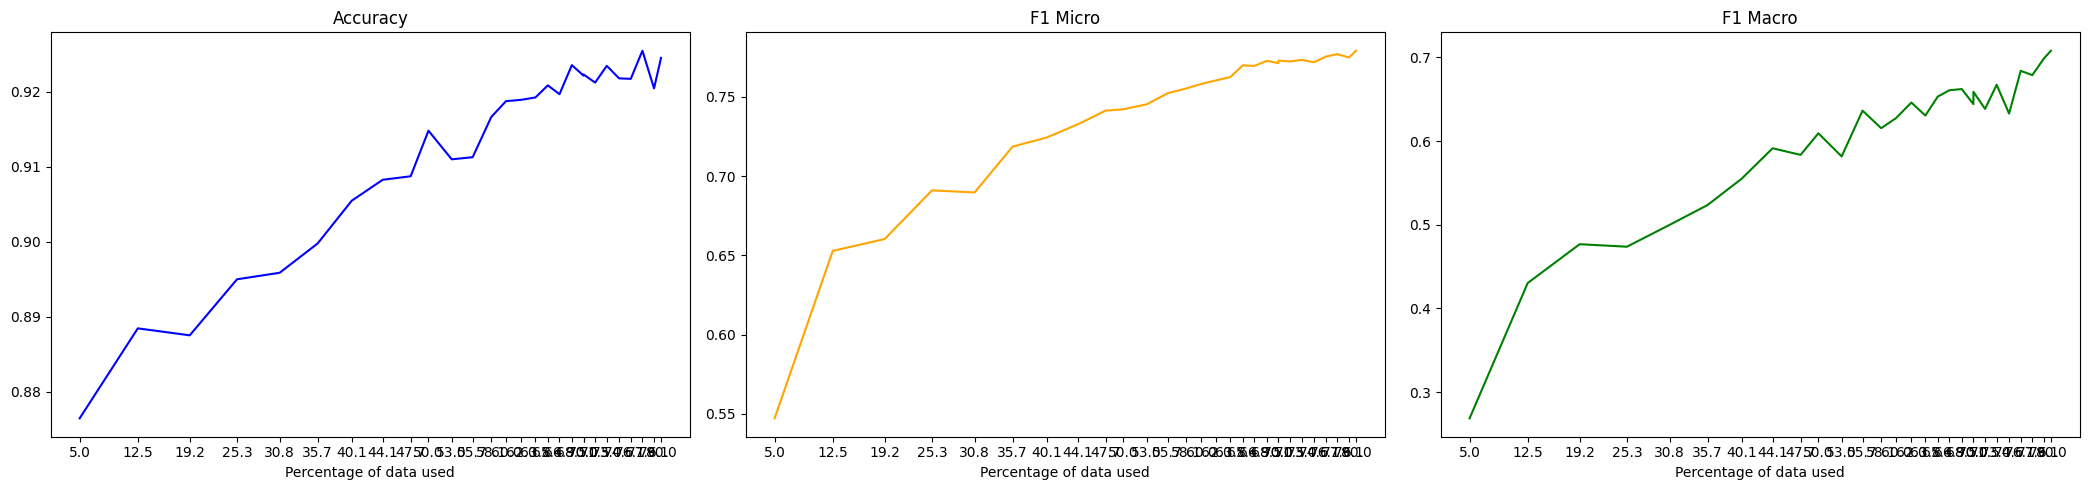

In [19]:
active_learning(seeds[0], 0)